In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score
#print(tf.__version__)
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.9.0


In [89]:
plt.rcParams.update({'figure.figsize':(13,5), 'figure.dpi':120})
# function to plot results
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

# function to calc RMSE and R^2; and also plot results
def eval_results(y, yhat, y_scaler = None):
    if y_scaler != None:
        yhat = y_scaler.inverse_transform(np.array(yhat).reshape(-1,1)).flatten()
        
    print("RMSE: ", mean_squared_error(y, yhat, squared = False))
    print("R^2: ", r2_score(y, yhat))

    
    plt.figure(figsize = (20,10))
    plot_series(np.arange(len(y)), y)
    plot_series(np.arange(len(yhat)), yhat)

/var/folders/yv/s556grcd04xf99g1bgg7tych0000gn/T/ipykernel_71660/2451845899.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(time[start:end], series[start:end], format)


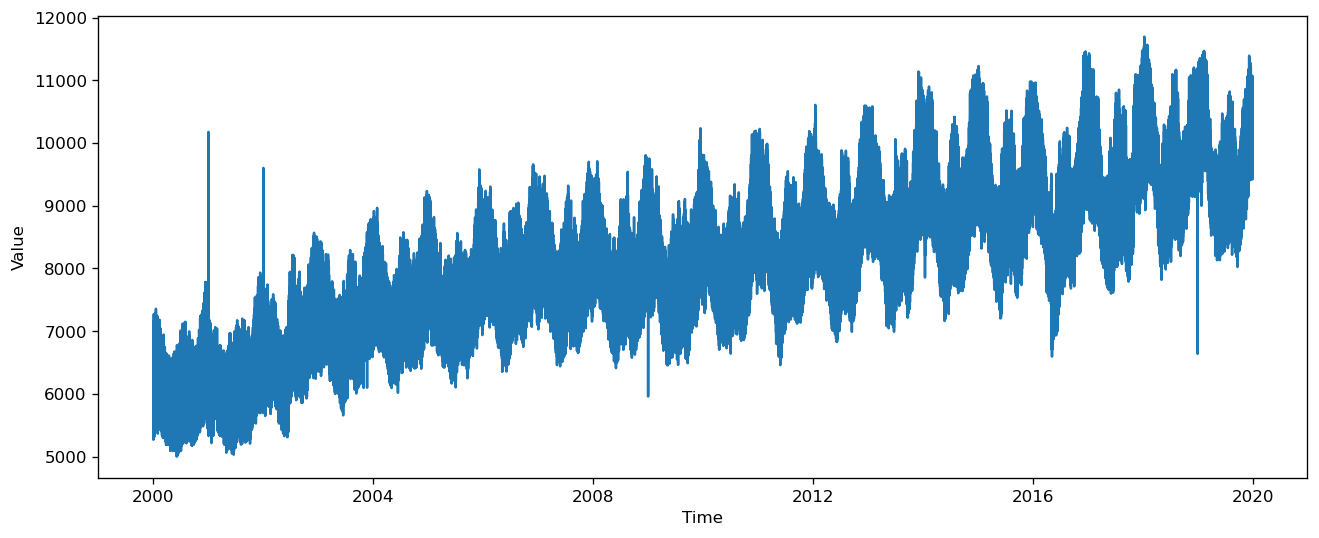

In [91]:
df = pd.read_csv(r'HourlyElectricityLoad.csv')
df['dt'] = pd.to_datetime(df['dt'])
df.sort_values(by='dt', inplace=True)
plot_series(df.dt,df.Load)


In [137]:
series = df["Load"].values
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
scaler = scaler.fit(series.reshape(-1,1))
normalized = pd.DataFrame(scaler.transform(series.reshape(-1,1)), columns = ["Load"])

In [158]:
split_time = len(df)-24*365
split_time2 = len(df)-24*7
#time = np.arange(np.shape(series)[0], dtype="float32")
#time_train = time[:split_time]
x_train = normalized[:split_time]
#time_valid = time[split_time:]
x_valid = normalized[split_time:split_time2]

raw_valid = df.Load[split_time2:]

/var/folders/yv/s556grcd04xf99g1bgg7tych0000gn/T/ipykernel_71660/1592568581.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  raw_valid = df.Load[split_time2:]


In [139]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df=None,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=256,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [140]:
wide_window = WindowGenerator(
    input_width=168, label_width=168, shift=168, train_df=x_train, val_df=x_valid,
    label_columns=["Load"])

wide_window

Total window size: 336
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 

In [147]:
tf.keras.backend.clear_session()
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.Huber(),#'mse'
                optimizer=tf.optimizers.Adam(), #tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=50,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    #tf.keras.layers.Dense(units=50),
    #tf.keras.layers.Dense(2, input_shape=[wide_window.input_width,2], activation="sigmoid"), 
    #tf.keras.layers.Dense(128, activation="relu"),
    #tf.keras.layers.Dense(64, activation="relu"),
    #tf.keras.layers.LSTM(64, activation='sigmoid',return_sequences=True),
    tf.keras.layers.GRU(180),
    # Shape => [batch, time, features],
    #tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(units=168)
])

history = compile_and_fit(lstm_model, wide_window, 2)

Epoch 1/50


2022-11-30 18:08:46.978173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 18:08:47.109527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 18:08:47.660545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


650/650 [==============================] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0828

2022-11-30 18:09:35.136800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-30 18:09:35.184278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


650/650 [==============================] - 51s 75ms/step - loss: 0.0034 - root_mean_squared_error: 0.0828 - val_loss: 0.0058 - val_root_mean_squared_error: 0.1080
Epoch 2/50
650/650 [==============================] - 47s 72ms/step - loss: 0.0041 - root_mean_squared_error: 0.0904 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0854
Epoch 3/50
650/650 [==============================] - 52s 80ms/step - loss: 0.0033 - root_mean_squared_error: 0.0813 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0821
Epoch 4/50
650/650 [==============================] - 68s 105ms/step - loss: 0.0028 - root_mean_squared_error: 0.0753 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0830
Epoch 5/50
650/650 [==============================] - 69s 106ms/step - loss: 0.0060 - root_mean_squared_error: 0.1098 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0943


In [151]:
# forecast = []

# for time in range(split_time, len(series)):
#     forecast.append(lstm_model(np.array(normalized[time - wide_window.input_width:time])[np.newaxis], training=False))
forecast = lstm_model(np.array(normalized[split_time2 - wide_window.input_width:split_time2])[np.newaxis], training=False)
#results = np.array(forecast)[:,0, 0]
#.to_numpy().flatten()
#results2 = np.exp(results)

In [156]:
results = np.array(forecast).flatten()
#normalized[split_time2 - wide_window.input_width:split_time2]

RMSE:  828.4807755415062
R^2:  -2.7408650734775364


/var/folders/yv/s556grcd04xf99g1bgg7tych0000gn/T/ipykernel_71660/2451845899.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(time[start:end], series[start:end], format)


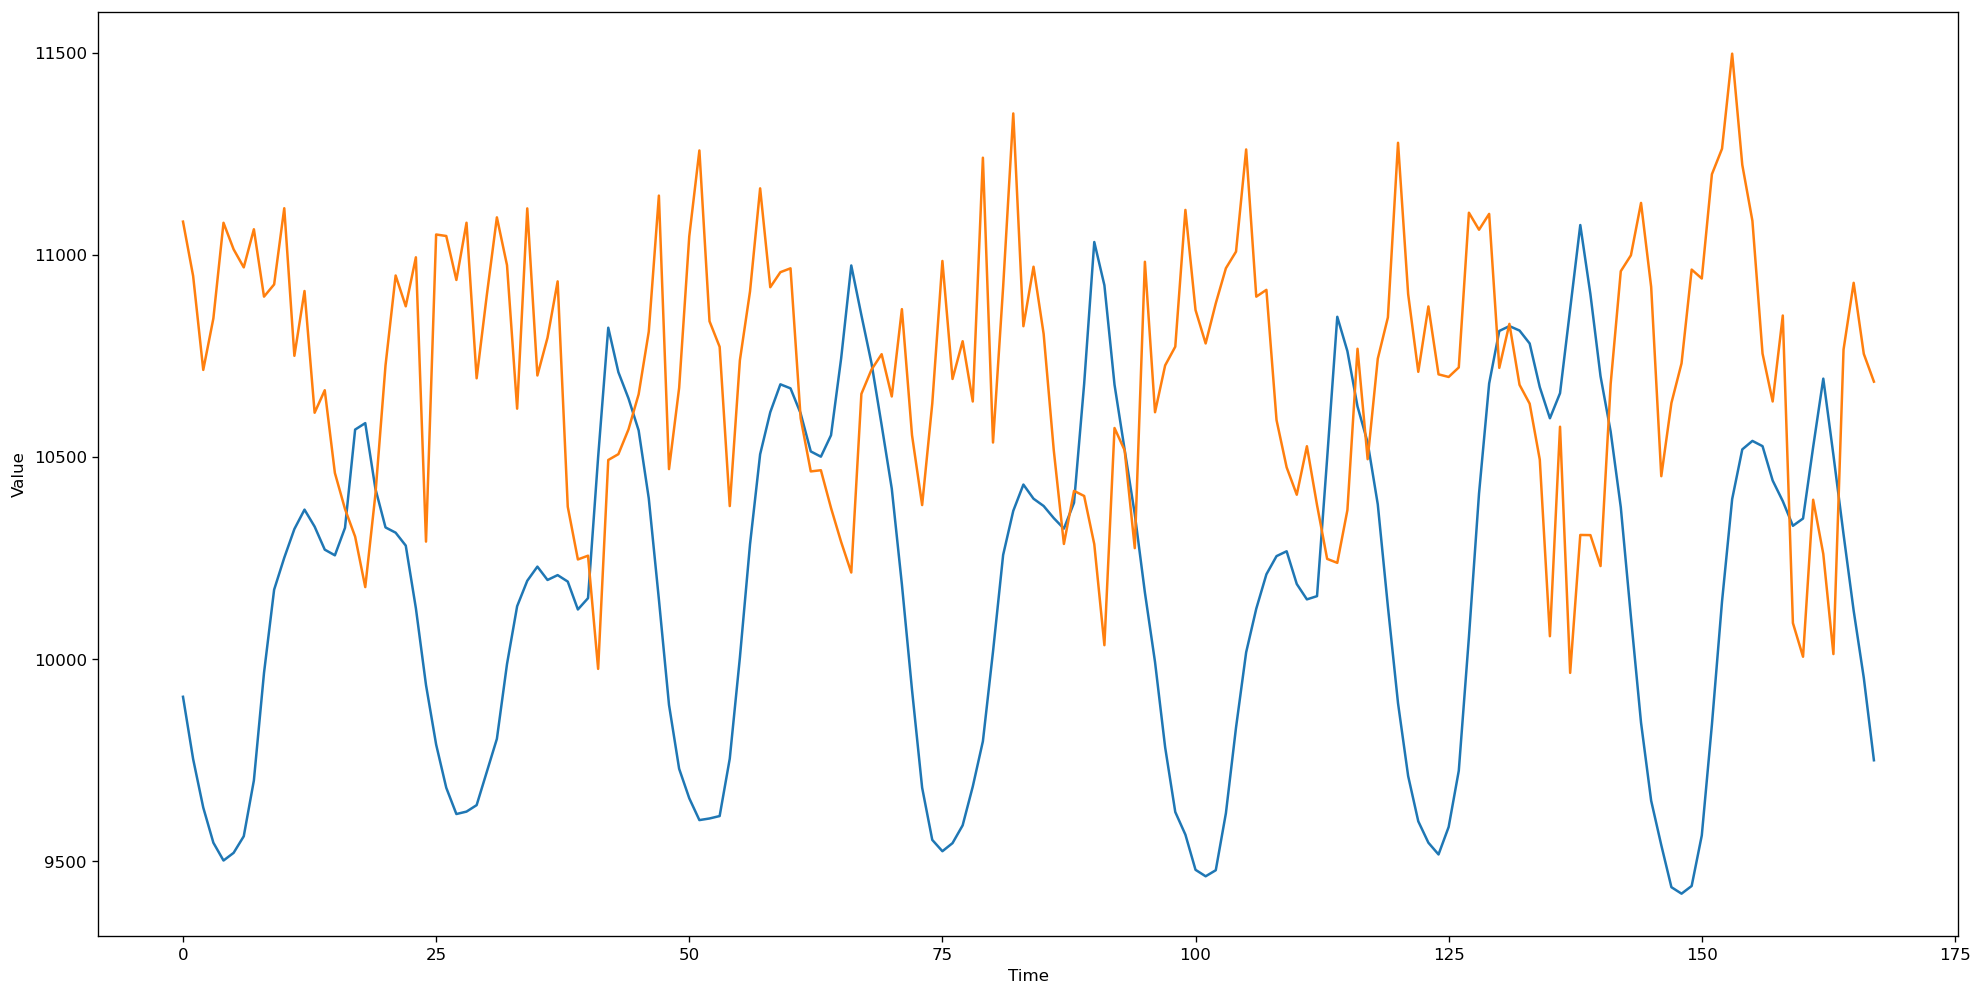

In [159]:
eval_results(raw_valid, results, y_scaler=scaler)

2022-11-27 13:51:41.908964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-27 13:51:41.980193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 680ms/step
RMSE:  157.89996246723365
R^2:  0.8812074913568534


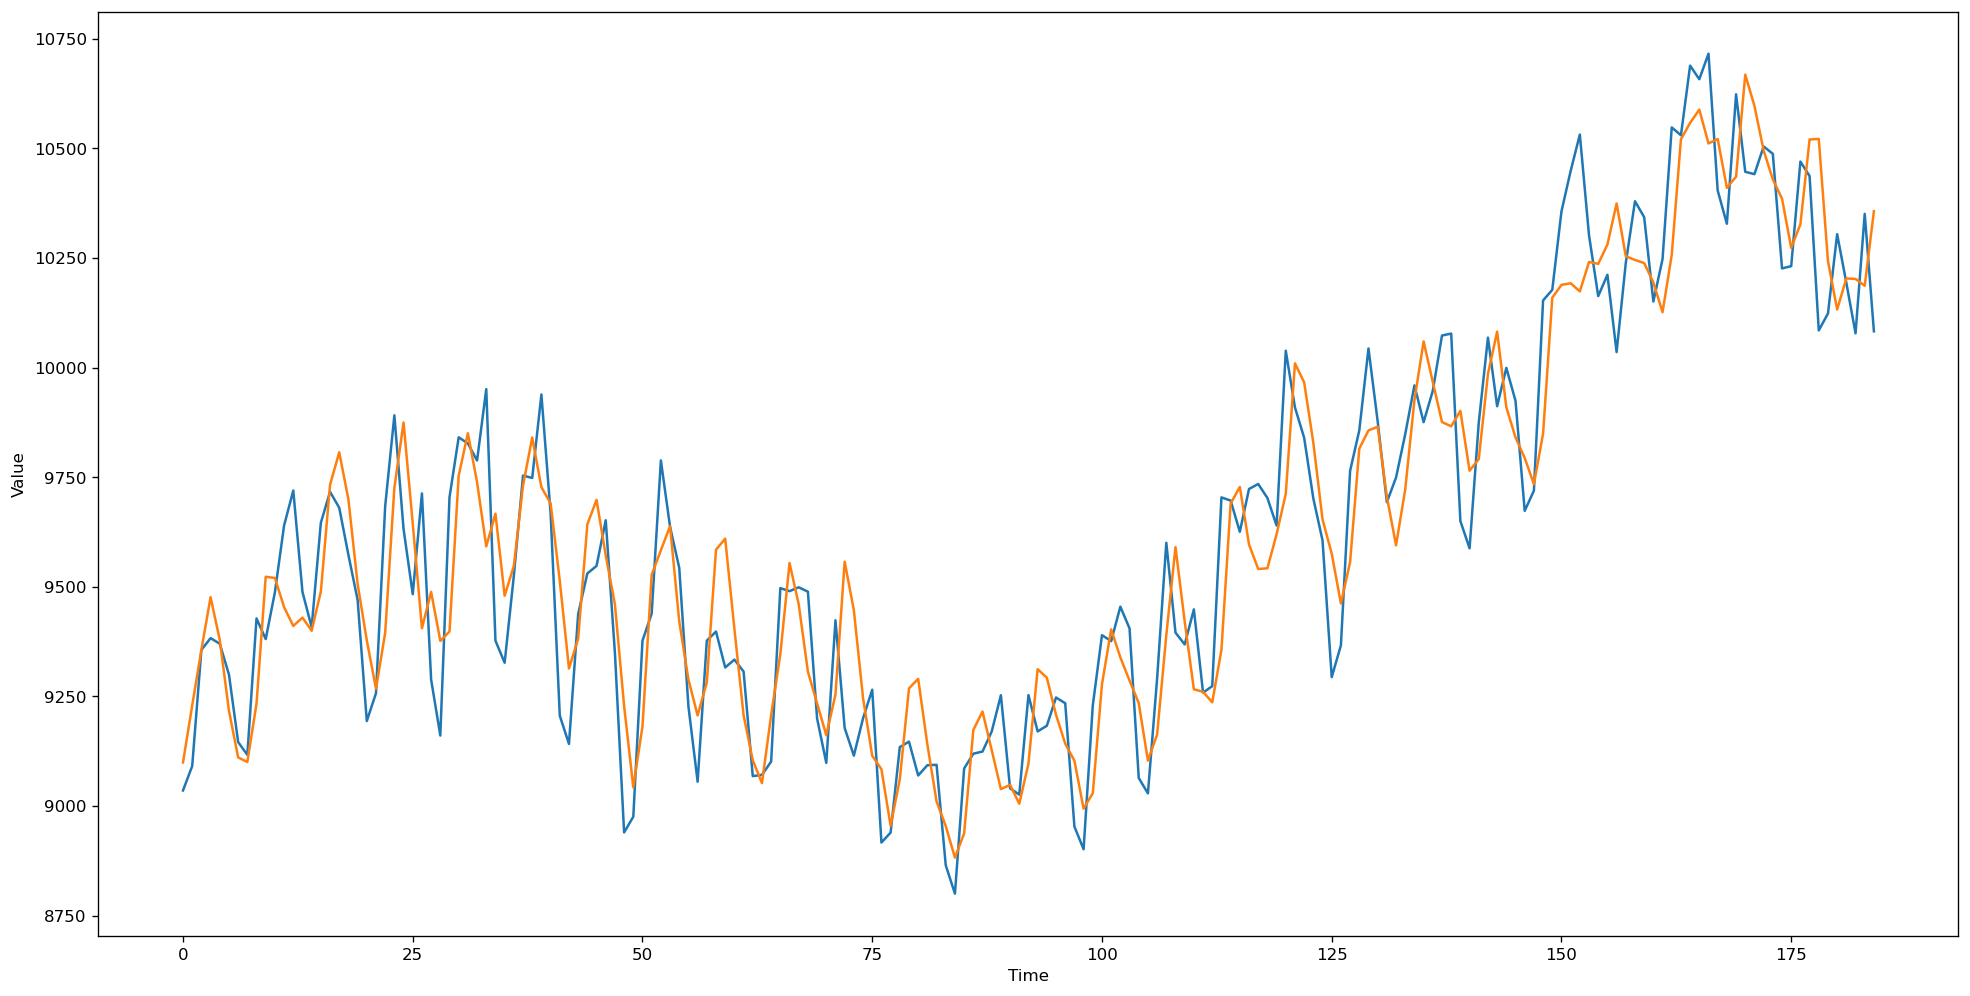

In [51]:
prediction = lstm_model.predict(wide_window.val)
eval_results(raw_valid[180:], prediction.flatten(), scaler)

In [18]:
features = []
targets = []
tau = 2 #forecasting periods

for t in range(1, tau+1):
    df["target_t" + str(t)] = df.Load.shift(-t)
    targets.append("target_t" + str(t))
    
for t in range(1,8):
    df["feat_ar" + str(t)] = df.Load.shift(t)
    #data["feat_ar" + str(t) + "_lag1y"] = data.target.shift(350)
    features.append("feat_ar" + str(t))

In [21]:
df.head(15)

,Date,Price,Load,target_t1,target_t2,feat_ar1,feat_ar2,feat_ar3,feat_ar4,feat_ar5,feat_ar6,feat_ar7
0,2000-01-01,18.696250,5805.708333,5994.125000,6405.416667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-02,41.727083,5994.125000,6405.416667,6424.916667,5805.708333,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-03,34.268333,6405.416667,6424.916667,6372.083333,5994.125000,5805.708333,NaN,NaN,NaN,NaN,NaN
3,2000-01-04,30.059167,6424.916667,6372.083333,6326.250000,6405.416667,5994.125000,5805.708333,NaN,NaN,NaN,NaN
4,2000-01-05,30.274167,6372.083333,6326.250000,6239.000000,6424.916667,6405.416667,5994.125000,5805.708333,NaN,NaN,NaN
5,2000-01-06,32.555417,6326.250000,6239.000000,5982.958333,6372.083333,6424.916667,6405.416667,5994.125000,5805.708333,NaN,NaN
6,2000-01-07,39.539167,6239.000000,5982.958333,5926.083333,6326.250000,6372.083333,6424.916667,6405.416667,5994.125000,5805.708333,NaN
7,2000-01-08,39.003750,5982.958333,5926.083333,6388.750000,6239.000000,6326.250000,6372.083333,6424.916667,6405.416667,5994.125000,5805.708333
8,2000-01-09,41.646250,5926.083333,6388.750000,6550.458333,5982.958333,6239.000000,6326.250000,6372.083333,6424.916667,6405.416667,5994.125000
9,2000-01-10,41.257083,6388.750000,6550.458333,6480.500000,5926.083333,5982.958333,6239.000000,6326.250000,6372.083333,6424.916667,6405.416667


In [160]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if (type(data) is list or len(data.shape) == 1) else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg, names[:n_vars*n_in], names[n_vars*n_in:]

In [161]:
data, features, targets = series_to_supervised(x_train, n_in=168, n_out=168, dropnan=True)

In [164]:
X_train = data[:split_time][features]
y_train = data[:split_time][targets]

X_val = data[split_time:][features]
y_val = data[split_time:][targets]
X_train

,var1(t-168),var1(t-167),var1(t-166),var1(t-165),var1(t-164),var1(t-163),var1(t-162),var1(t-161),var1(t-160),var1(t-159),...,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
168,0.104658,0.083010,0.065841,0.047626,0.041356,0.040311,0.044640,0.059719,0.074948,0.080920,...,0.228874,0.223649,0.239922,0.285010,0.272171,0.250224,0.234697,0.211108,0.176918,0.134219
169,0.083010,0.065841,0.047626,0.041356,0.040311,0.044640,0.059719,0.074948,0.080920,0.102120,...,0.223649,0.239922,0.285010,0.272171,0.250224,0.234697,0.211108,0.176918,0.134219,0.095402
170,0.065841,0.047626,0.041356,0.040311,0.044640,0.059719,0.074948,0.080920,0.102120,0.120036,...,0.239922,0.285010,0.272171,0.250224,0.234697,0.211108,0.176918,0.134219,0.095402,0.071962
171,0.047626,0.041356,0.040311,0.044640,0.059719,0.074948,0.080920,0.102120,0.120036,0.135861,...,0.285010,0.272171,0.250224,0.234697,0.211108,0.176918,0.134219,0.095402,0.071962,0.057032
172,0.041356,0.040311,0.044640,0.059719,0.074948,0.080920,0.102120,0.120036,0.135861,0.143326,...,0.272171,0.250224,0.234697,0.211108,0.176918,0.134219,0.095402,0.071962,0.057032,0.052105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166387,0.882502,0.861003,0.820394,0.762168,0.708271,0.673335,0.655420,0.642729,0.639893,0.646312,...,0.860854,0.873096,0.878770,0.866378,0.863243,0.856076,0.867274,0.899672,0.899373,0.875784
166388,0.861003,0.820394,0.762168,0.708271,0.673335,0.655420,0.642729,0.639893,0.646312,0.671544,...,0.873096,0.878770,0.866378,0.863243,0.856076,0.867274,0.899672,0.899373,0.875784,0.850851
166389,0.820394,0.762168,0.708271,0.673335,0.655420,0.642729,0.639893,0.646312,0.671544,0.727829,...,0.878770,0.866378,0.863243,0.856076,0.867274,0.899672,0.899373,0.875784,0.850851,0.832637
166390,0.762168,0.708271,0.673335,0.655420,0.642729,0.639893,0.646312,0.671544,0.727829,0.806211,...,0.866378,0.863243,0.856076,0.867274,0.899672,0.899373,0.875784,0.850851,0.832637,0.822036


In [165]:
y_train

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),...,var1(t+158),var1(t+159),var1(t+160),var1(t+161),var1(t+162),var1(t+163),var1(t+164),var1(t+165),var1(t+166),var1(t+167)
168,0.095402,0.071962,0.057032,0.052105,0.050463,0.054792,0.069424,0.102419,0.142729,0.167662,...,0.286354,0.286205,0.305763,0.340848,0.327859,0.301284,0.281726,0.258286,0.231711,0.204688
169,0.071962,0.057032,0.052105,0.050463,0.054792,0.069424,0.102419,0.142729,0.167662,0.183338,...,0.286205,0.305763,0.340848,0.327859,0.301284,0.281726,0.258286,0.231711,0.204688,0.168259
170,0.057032,0.052105,0.050463,0.054792,0.069424,0.102419,0.142729,0.167662,0.183338,0.191699,...,0.305763,0.340848,0.327859,0.301284,0.281726,0.258286,0.231711,0.204688,0.168259,0.146163
171,0.052105,0.050463,0.054792,0.069424,0.102419,0.142729,0.167662,0.183338,0.191699,0.188713,...,0.340848,0.327859,0.301284,0.281726,0.258286,0.231711,0.204688,0.168259,0.146163,0.134070
172,0.050463,0.054792,0.069424,0.102419,0.142729,0.167662,0.183338,0.191699,0.188713,0.178710,...,0.327859,0.301284,0.281726,0.258286,0.231711,0.204688,0.168259,0.146163,0.134070,0.123918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166387,0.850851,0.832637,0.822036,0.799642,0.764109,0.724246,0.698716,0.683936,0.681995,0.683786,...,0.858615,0.873544,0.873395,0.865482,0.857420,0.851448,0.853090,0.884742,0.914452,0.895342
166388,0.832637,0.822036,0.799642,0.764109,0.724246,0.698716,0.683936,0.681995,0.683786,0.693192,...,0.873544,0.873395,0.865482,0.857420,0.851448,0.853090,0.884742,0.914452,0.895342,0.865632
166389,0.822036,0.799642,0.764109,0.724246,0.698716,0.683936,0.681995,0.683786,0.693192,0.709316,...,0.873395,0.865482,0.857420,0.851448,0.853090,0.884742,0.914452,0.895342,0.865632,0.841296
166390,0.799642,0.764109,0.724246,0.698716,0.683936,0.681995,0.683786,0.693192,0.709316,0.736936,...,0.865482,0.857420,0.851448,0.853090,0.884742,0.914452,0.895342,0.865632,0.841296,0.828158


In [163]:
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.ensemble import RandomForestRegressor
splits = TimeSeriesSplit(n_splits=3, max_train_size=365*15*24)
rfr = RandomForestRegressor()
# Create a dictionary of hyperparameters to search
rfr_grid = {"n_estimators": [500], 
        'max_depth': [3, 5, 10, 20, 30], 
        'max_features': [1, 7, 30, 60, 90],#'max_features': [4, 8, 16, 32, 59], 
        'random_state': [123]}
rfr_paramGrid = ParameterGrid(rfr_grid)

def TimeSplit_ModBuild(model, paramGrid, splits, X, y):
    from sklearn.model_selection import TimeSeriesSplit
    from sklearn.metrics import mean_squared_error

    #Loop over each time split and for each
    for train_index, val_index in splits.split(X_train):
        _X_train_ = X.iloc[train_index]
        _y_train_ = y.iloc[train_index]
        _X_val_ = X.iloc[val_index]
        _y_val_ = y.iloc[val_index]

        train_scores = []
        val_scores = []
        #models = []
        
        # Loop through the parameter grid, set the hyperparameters, and save the scores
        for g in paramGrid:
            model.set_params(**g)
            model.fit(_X_train_, _y_train_)
            p_train = model.predict(_X_train_)
            p_val = model.predict(_X_val_)
            score_train = np.mean(mean_squared_error(_y_train_, p_train))
            score_val = np.mean(mean_squared_error(_y_val_, p_val))
            train_scores.append(score_train)
            val_scores.append(score_val)
            #models.append(model)
            best_idx = np.argmin(val_scores)
            
        print("Best-Fold HyperParams:: ", paramGrid[best_idx])
        print("Best-Fold Train RMSE: ", train_scores[best_idx])
        print("Best-Fold Val RMSE: ",val_scores[best_idx])
        print("\n")
        
    #Return most recent model
    return train_scores, val_scores, best_idx


CV_rfr_tup = TimeSplit_ModBuild(rfr, rfr_paramGrid, splits, X_train, y_train["var1(t)"])

Best-Fold HyperParams::  {'random_state': 123, 'n_estimators': 500, 'max_features': 90, 'max_depth': 20}
Best-Fold Train RMSE:  1.0946351291210652e-05
Best-Fold Val RMSE:  0.0004666317173419605




KeyboardInterrupt: 

In [89]:
best_rfr_idx = CV_rfr_tup[2]
best_rfr_grid = rfr_paramGrid[best_rfr_idx]
best_rfr = RandomForestRegressor().set_params(**best_rfr_grid).\
    fit(X_train, y_train["var1(t)"])

RMSE:  148.5246702903556
R^2:  0.8948952861523308


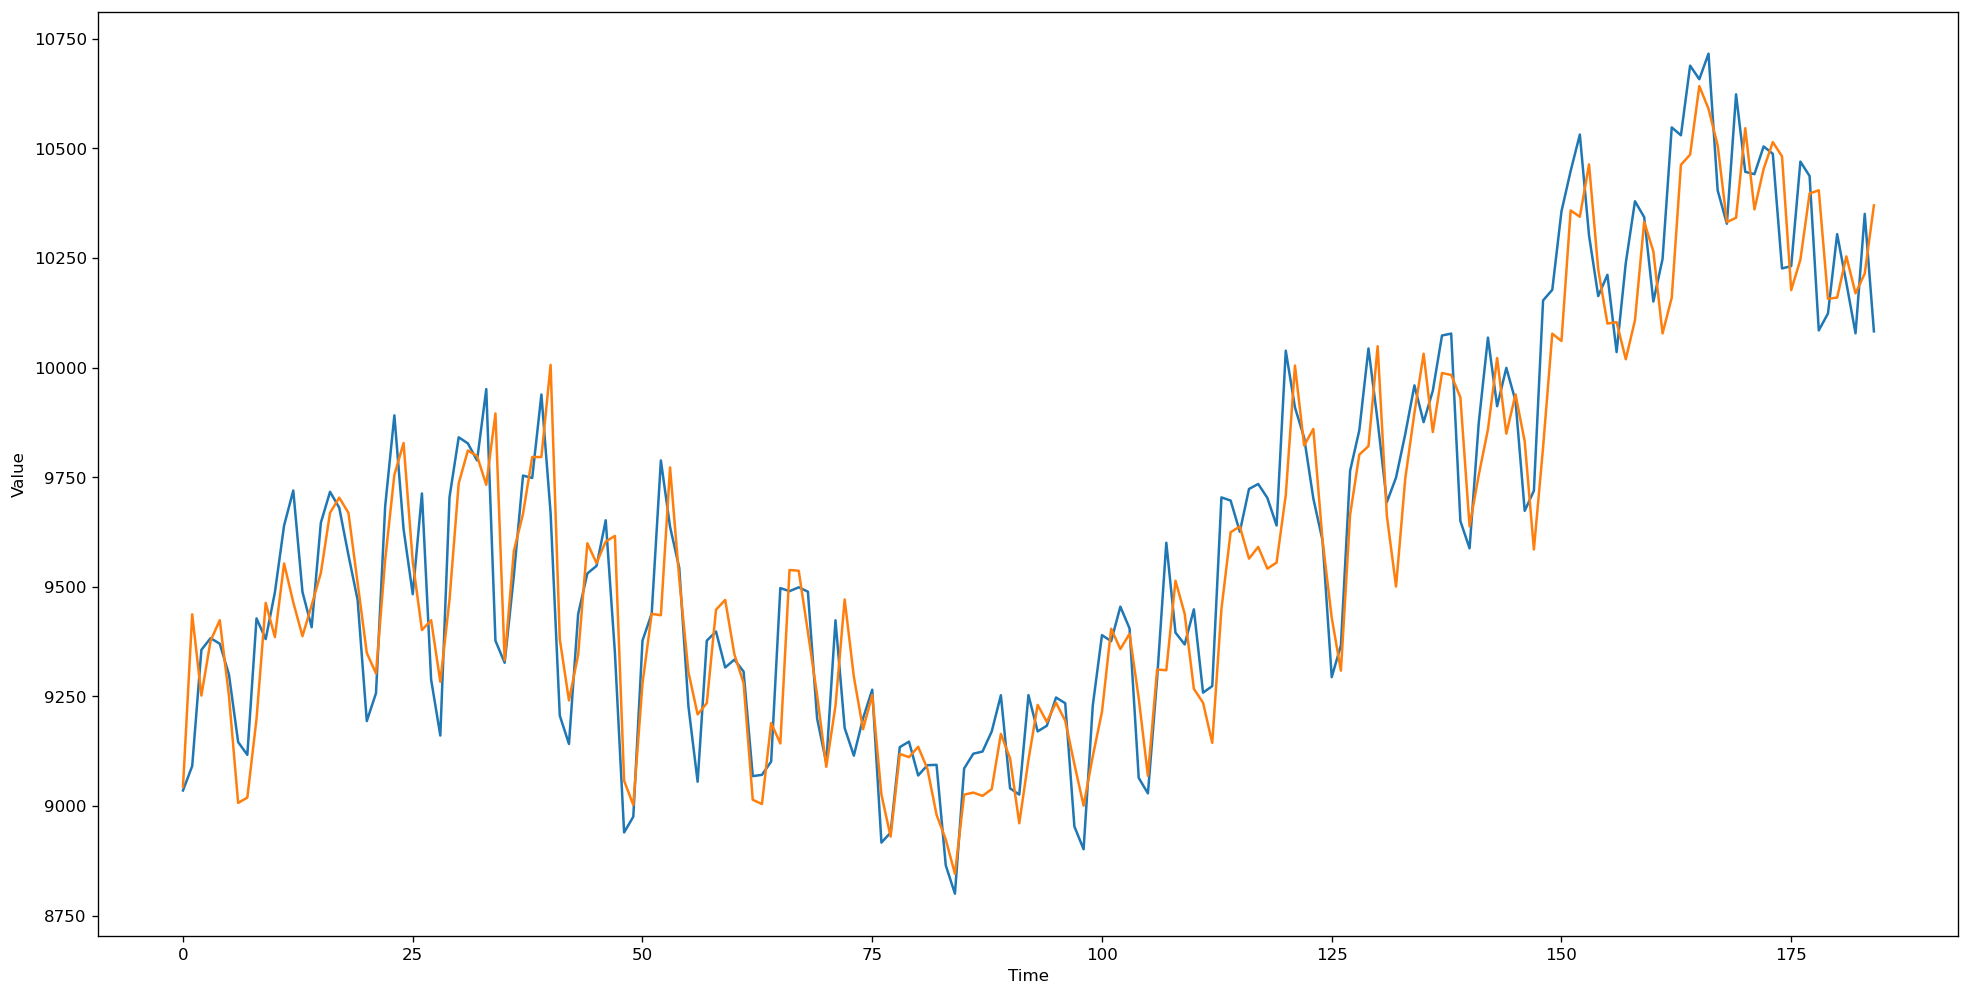

In [91]:
p_test = best_rfr.predict(X_val)
eval_results(raw_valid[180:], p_test[150:])

In [98]:
from prophet import Prophet

df_prophet = df[:split_time]
df_prophet.columns=["ds","y"]

#series['y'] = series['y'].astype(float)
m = Prophet()
m.fit(df_prophet)



12:47:52 - cmdstanpy - INFO - Chain [1] start processing
12:48:37 - cmdstanpy - INFO - Chain [1] done processing


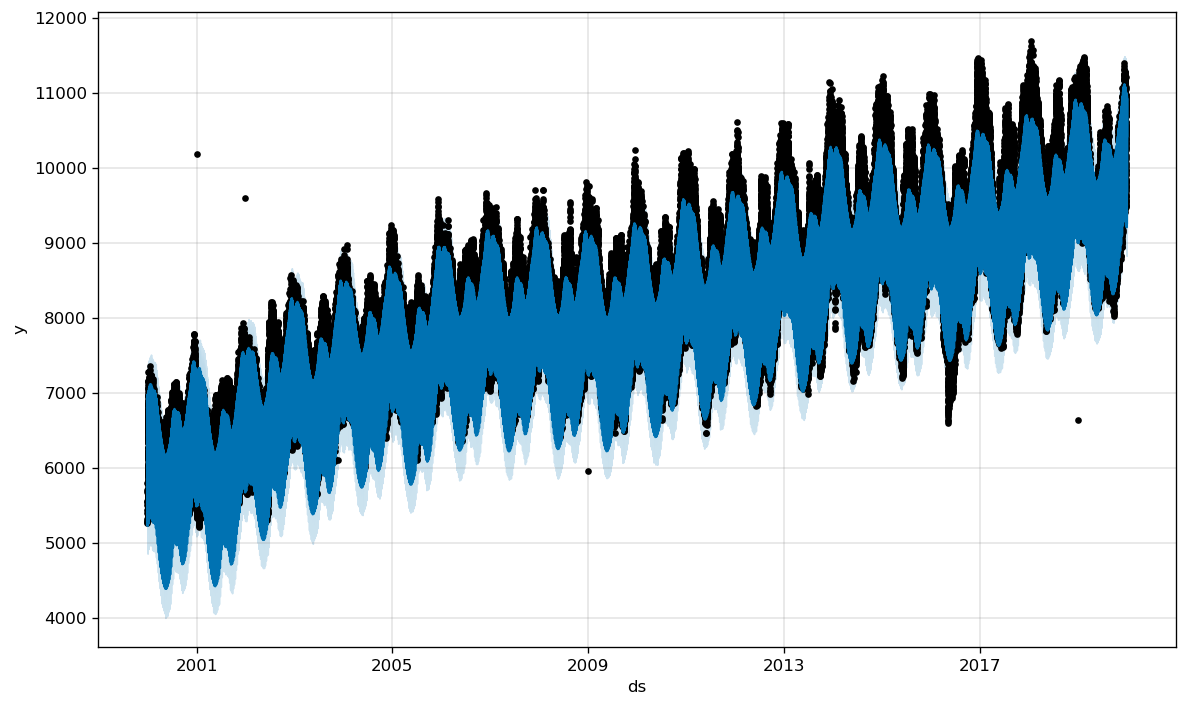

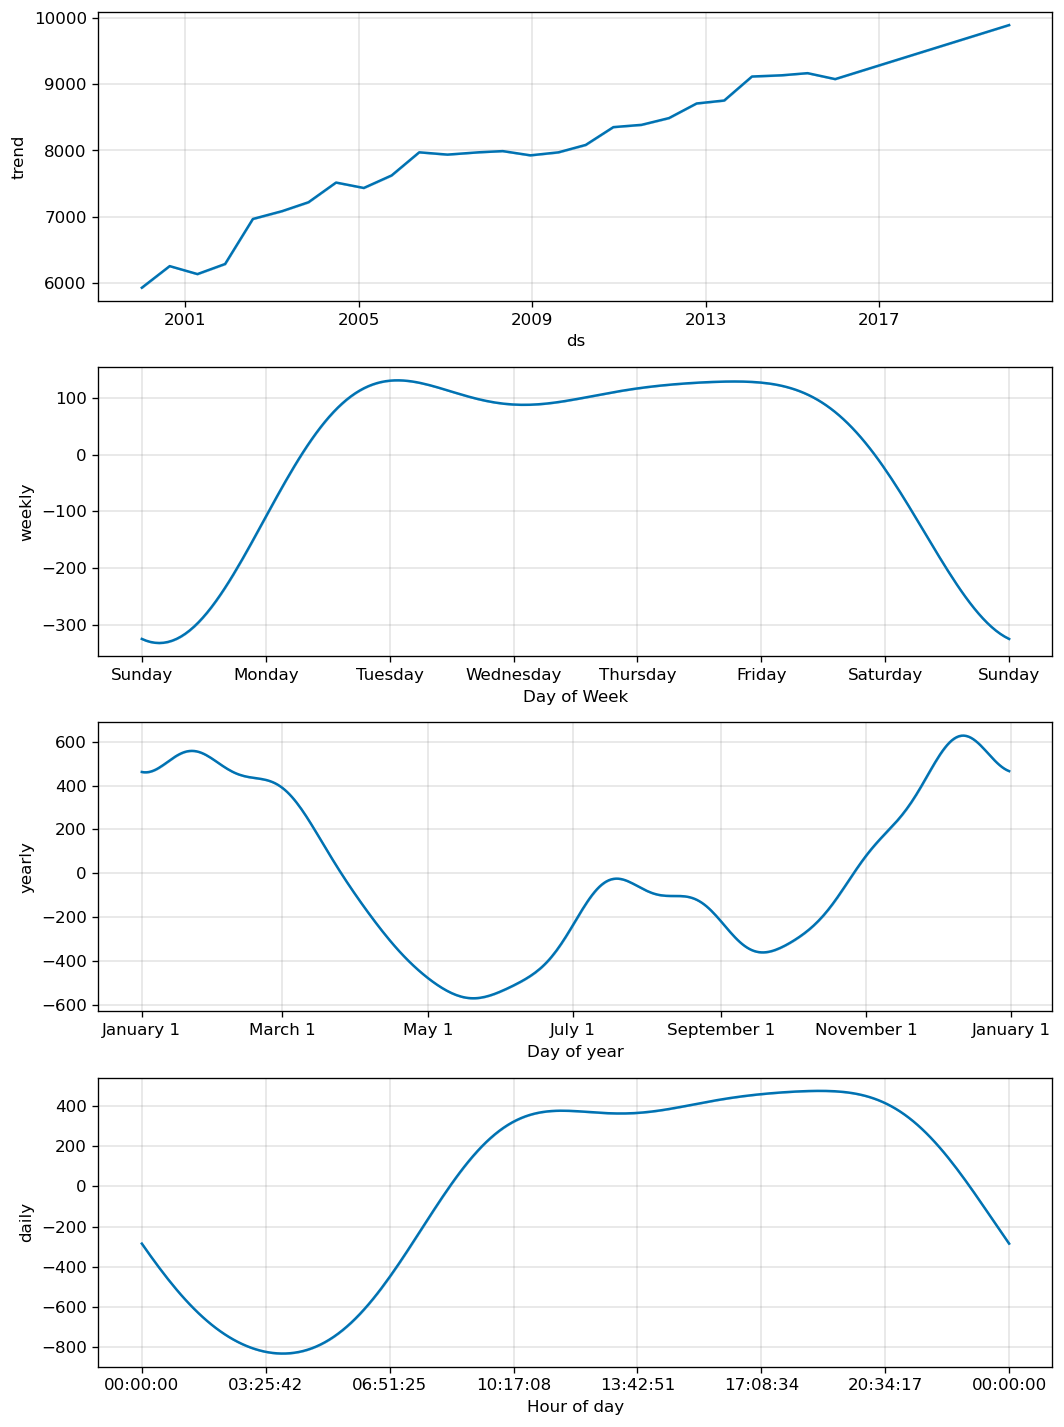

In [122]:
future = m.make_future_dataframe(periods=168, freq='H')

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

RMSE:  318.8753175059631
R^2:  0.445822381851839


/var/folders/yv/s556grcd04xf99g1bgg7tych0000gn/T/ipykernel_71660/2451845899.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(time[start:end], series[start:end], format)


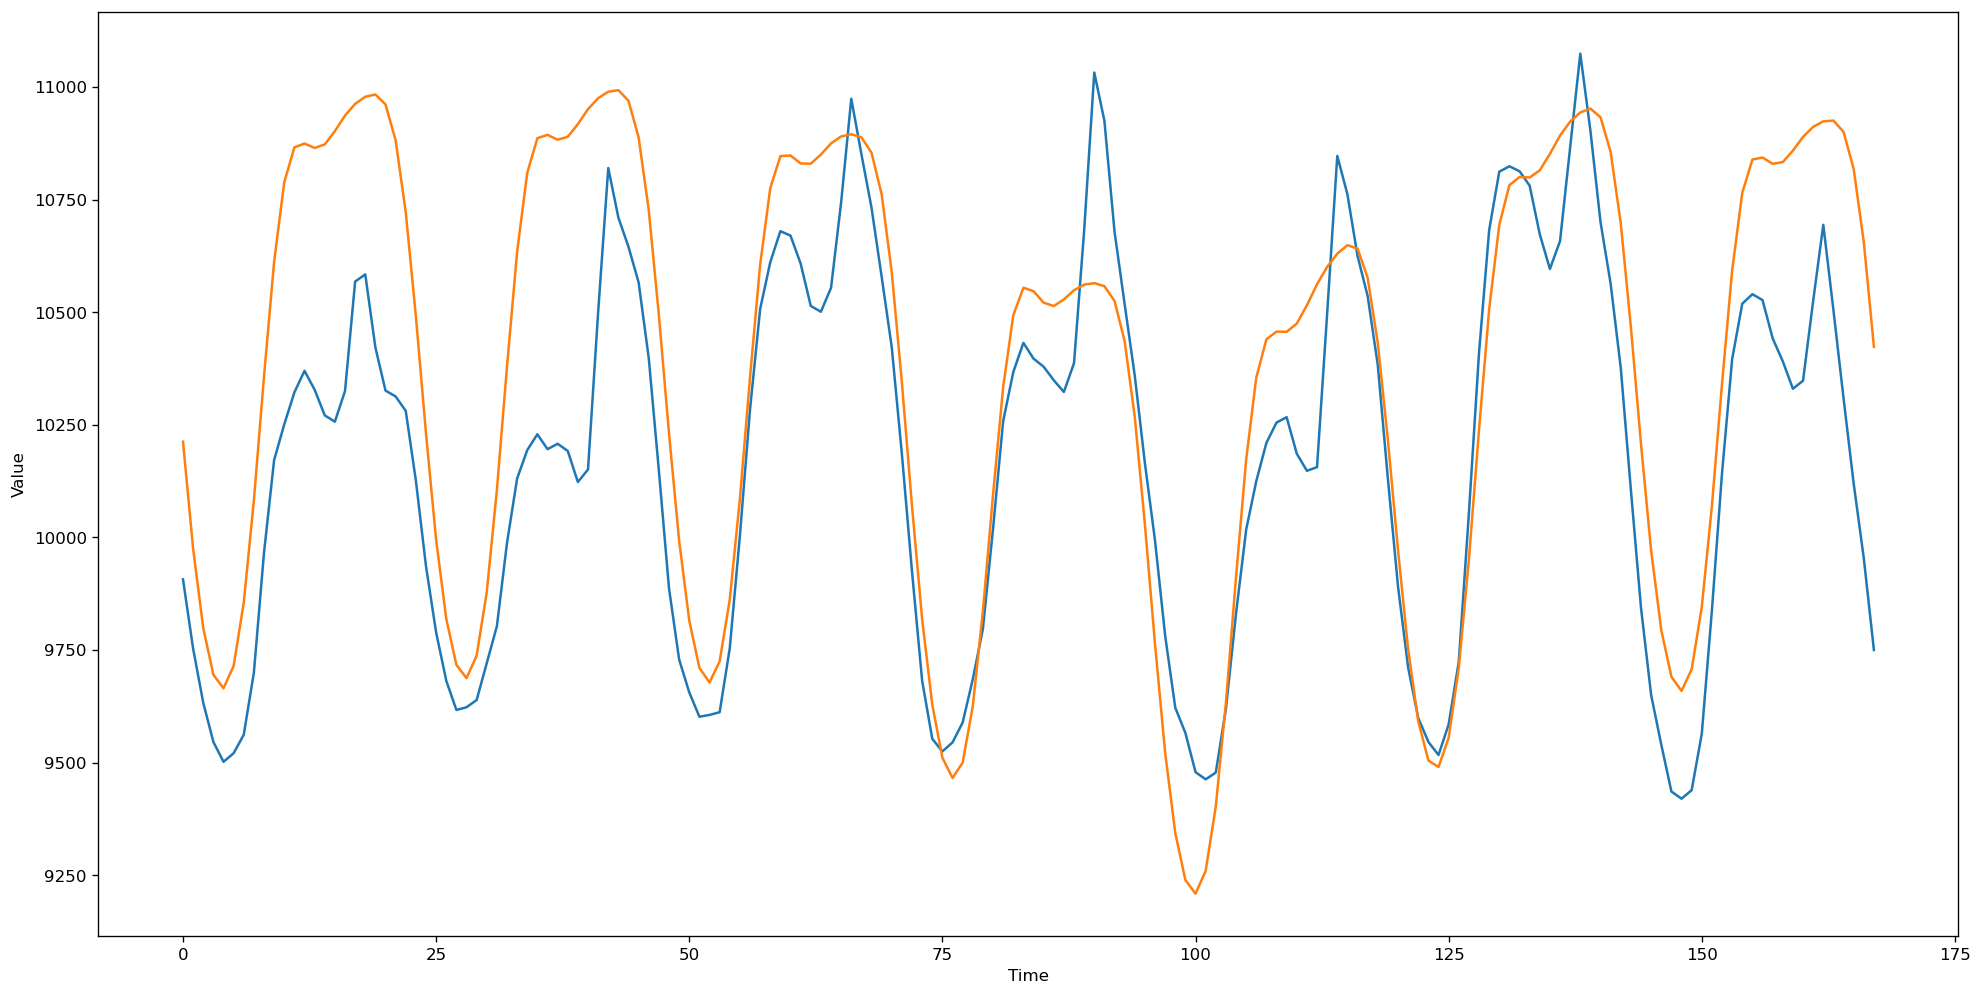

In [125]:
eval_results(raw_valid, forecast.yhat[-168:])